<a href="https://colab.research.google.com/github/HugoKD/ML/blob/main/KNN_GNB_LogisticReg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## A project to present with a pedagogic way the topic of KNN, Gaussian Naive Bayes classifier and Logisitic Regression classifier

In [ ]:
# Import Packages
import typing
import numpy as np
import scipy
import matplotlib.pyplot as plt
from typing import Type
%matplotlib inline

from scipy.stats import multivariate_normal

# NOTE: Do NOT change the order of this import call
from keras.datasets import mnist, fashion_mnist
import tensorflow as tf
# NOTE: Keras has only been used here to import the dataset, you're
# not allowed to use it anywhere else (we haven't either!)

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
rng = np.random.RandomState(seed)


In [ ]:
# Helper Function
def iterate_samples(batch_size, sample_set, label_set, shuffle=True):
    # set random seed reproducibility
    np.random.seed(42)

    order = np.arange(sample_set.shape[0])
    if shuffle:
        np.random.shuffle(order)

    for i in range(0, sample_set.shape[0], batch_size):
        batch_samples = sample_set[order[i : i + batch_size]]
        batch_labels = label_set[order[i : i + batch_size]]
        yield batch_samples, batch_labels

Next, we load the MNIST dataset.

In [ ]:
# Load  MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()


# Shuffle the training set
permuted = np.random.permutation(len(x_train))
x_train, y_train = x_train[permuted], y_train[permuted]

print(f"Number of images for training: {x_train.shape[0]}")
print(f"Number of images for testing: {x_test.shape[0]}")
print(f"Size of  MNIST images: {x_train[0].shape}")

Number of images for training: 60000
Number of images for testing: 10000
Size of  MNIST images: (28, 28)


Normalize the training and test data as following.

In [ ]:
max_value = np.max(x_train)

train_images = x_train / max_value
test_images = x_test / max_value

# Vectorize the data
train_images = train_images.reshape((train_images.shape[0], -1))
test_images = test_images.reshape((test_images.shape[0], -1))

print(f"Training inputs' shape after vectorization: {train_images.shape}")
print(f"Testing inputs' shape after vectorization: {test_images.shape}")

Training inputs' shape after vectorization: (60000, 784)
Testing inputs' shape after vectorization: (10000, 784)


### 1. k-Nearest Neighbour Classification

In this section, we will be looking at the k-nearest neighbours algorithm for classifiying 10 different categores in the MNIST dataset. In particular, we will learn about the following:

1. Implement a function that classifies MNIST using the kNN algorithm.
2. Perform a brief cross-validation to get the best k.

Implementation of the distance function `get_distance`.

In [ ]:
from scipy.spatial import distance

def get_distance(A: np.ndarray, B: np.ndarray) -> np.ndarray:
    """Computes the Euclidean distance between two arrays

    Args:
        A (np.ndarray): Numpy array of shape [num_samples_a x num_features]
        B (np.ndarray): Numpy array of shape [num_samples_b x num_features]

    Returns:
        np.ndarray: Numpy array of shape [num_samples_a x num_samples_b] where
                    each column contains the distance between one element in
                    matrix_b and all elements in matrix_a
    """

    distances = distance.cdist(A, B, 'euclidean')

    return distances

Implementation of the `get_k_neighbors` function to the get the labels of the k-nearest neighbours from the training set.

In [ ]:
def get_k_neighbors(distances: np.ndarray, labels: np.ndarray, k: int) -> np.ndarray:
    k_nearest_labels = np.empty((k, distances.shape[1]), dtype=labels.dtype)
    for i in range(distances.shape[1]):
        k_indices = np.argpartition(distances[:, i], k)[:k]
        #The array will be sort such that, the k-th element is in its place, all the element before is smaller and all the element after is greater -> complexity = O(n)
        k_nearest_labels[:,i]= labels[k_indices]
    return k_nearest_labels

Implementation of the `get_prediction` function that returns the label class that occurs most frequently.

In [ ]:
import numpy as np

def get_prediction(nearest_labels: np.ndarray) -> np.ndarray:
    """Gets the best prediction, i.e. the label class that occurs most frequently

    Args:
        nearest_labels (np.ndarray): Numpy array of shape [k x num_test_samples] obtained from the output of the get_k_neighbors function

    Returns:
        np.array: Numpy array of shape [num_test_samples] containing the best prediction for each test sample
    """
    # Count the occurrences of each label in the nearest_labels array
    label_counts = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=nearest_labels)
    return label_counts


Now, using these functions, we will run the k-NN classifier on a subset of the MNIST dataset! Particularly, we will use 50,000 samples for training, 10,000 samples for validation, and 10,000 samples for testing.

In [ ]:
n_train_samples = 50000
n_val_samples = 10000
n_test_samples = 10000

# define the training set and labels
train_set = train_images[:n_train_samples]
train_labels = y_train[:n_train_samples]
print(f"Training set shape: {train_set.shape}")

# define the validation set and labels
val_set = train_images[-n_val_samples:]
val_labels = y_train[-n_val_samples:]
print(f"Validaton set shape: {val_set.shape}")

# define the test set and labels
test_set = test_images[:n_test_samples]
test_labels = y_test[:n_test_samples]
print(f"Test set shape: {test_set.shape}")

Training set shape: (50000, 784)
Validaton set shape: (10000, 784)
Test set shape: (10000, 784)


In [ ]:
def knn_classifier(training_set: np.ndarray, training_labels: np.ndarray,
                  test_set: np.ndarray, test_labels: np.ndarray, k: int) -> float:
  """
  Performs k-nearest neighbour classification

  Args:
    training_set (np.ndarray): Vectorized training images (shape: [num_train_samples x num_features])
    training_labels (np.ndarray): Training labels (shape: [num_train_samples, 1])
    test_set (np.ndarray): Vectorized test images (shape: [num_test_samples x num_features])
    test_labels (np.ndarray): Test labels (shape: [num_test_samples, 1])
    k (int): number of nearest neighbours

  Returns:
    accuracy (float): the accuracy in %
  """

  dists = get_distance(A=training_set, B=test_set)

  nearest_labels = get_k_neighbors(distances=dists, labels=training_labels, k=k)

  # from the nearest labels above choose the label classes that occurs most frequently
  predictions = get_prediction(nearest_labels)

  # calculate and return accuracy of the predicitions
  accuracy = (np.equal(predictions, test_labels).sum())/len(test_set) * 100.0

  return accuracy

Choice of hyperparamaters k :

In [ ]:
# dictionary to store the k values as keys and the validation accuracies as the values
val_accuracy_per_k = {}

for k in [2, 4, 6]:
    val_accuracy_per_k[k] = knn_classifier(train_set, train_labels, val_set, val_labels, k)

best_k = max(val_accuracy_per_k, key=val_accuracy_per_k.get)
print(f"Best validation accuracy of {val_accuracy_per_k[best_k]} % for k={best_k}")

Best validation accuracy of 96.92 % for k=4


In [ ]:
# Now, based on the best value of k, we run the kNN classifier on the test set.
test_accuracy = knn_classifier(train_set, train_labels, test_set, test_labels, k=best_k)
print(test_accuracy)

96.53


The test accuracy with k=4 is 96.53
 %.

### 2.  Classification using Gaussian Naive Bayes

In this section, we will use the Gaussian Naive Bayes (GNB) classifier on the MNIST dataset. The GNB classifier belongs to the family of probabilistic classifiers based on the application of Bayes' Theorem. The term "naive" in naive Bayes classifiers comes from the fact that they have a strong independence assumptions between the features. In particular, it assumes that the value of a particular feature is independent of the value of another feature, _given the class variable_.

Consider the training set $\{( x^{(1)},y^{(1)} ), \ldots, ( x^{(N)},y^{(N)} )) \}$ of N labeled examples, and the input features are $x^{(i)} \in \mathbb{R}^n$. Since we are interested in multi-class classification, the label $y$ can take K different values i.e. $y^{(i)} \in \{1, 2, \ldots, K\}$. The GNB model assumes that the **class-conditional densities** are distributed according to a multi-variate Gaussian distribution. In other words, the probability of observing the data $x^{(i)}$ given the class variable (also known as, _likelihood_) is given by a Gaussian distribution as shown below:

$$
P(x \mid y=k, \mu_k, \Sigma_k) = \mathcal{N}(x \mid \mu_k, \Sigma_k)
$$
where $\mu_k$ denotes the class-specific mean vector and $\Sigma_k$ denotes the class-specific covariance matrix (meaning that each class has its own mean vector and the covariance matrix). Note that since we have a separate covariance matrix for each class $k$, the covariance matrices are not shared among all the classes.

Given the likelihood of the model, we can now calculate the posterior probability, that is, the probability of a label belonging to a particular class given the data $x^{(i)}$, using Bayes' theorem as follows:

$$
P(y=k \mid x, \mu_k, \Sigma_k) = \frac{P (x \mid y=k, \mu_k, \Sigma_k) P(y=k)}{\sum_{c=1}^K P (x \mid y=c, \mu_c, \Sigma_c) P(y=c)}
$$
where $P(y=k)$ denotes the prior probability of a label belonging to a particular class. The denominator is essentially a normalization constant and is not technically required to be implemented. Observe that it this likelihood $P (x \mid y=k, \mu_k, \Sigma_k)$ that is distributed according to a multi-variate Gaussian distribution given below:

$$
P(x \mid y=k, \mu_k, \Sigma_k) = \frac{1}{(2 \pi)^{K/2} | \Sigma_k |^{1/2} } \exp \left( -\frac{1}{2} (x - \mu_k)^{T} \Sigma_k^{-1} (x - \mu_k) \right)
$$
where $| \Sigma_k |$ denotes the determinant of the covariance matrix, and $K$ denotes the number of classes. An important note here is that the probabilities are small and in the case of high dimensionality they tend to be very close to zero and result in numerical underflow issues. Therefore, we will be considering the _log_ of the likelihood function instead. Hence, the resulting log-likelihood can be written as:

$$
\log P(x \mid y=k, \mu_k, \Sigma_k) = - \frac{K}{2} \log(2 \pi) - \frac{1}{2} \log(| \Sigma_k |) - \frac{1}{2} (x - \mu_k)^{T} \Sigma_k^{-1} (x - \mu_k)
$$

Likewise, the log-posterior can be written as:
$$
\log P(y=k \mid x, \mu_k, \Sigma_k) \propto \log P (x \mid y=k, \mu_k, \Sigma_k) + \log P(y=k) - \log (\textrm{const.})
$$
Note that we have used the $\propto$ symbol above which indicates that the log of the posterior probability density for a class can be computed as the sum of the log-likelihood and the log prior probability densities, _upto_ the log of the normalization constant.

Now, given the theory, we will have to do two main implementations. In the first, we will compute the class-specific mean and covariance vectors and the prior probabilities for each class. In the second question, we'll required to use these 3 quantities to calculate the posterior probability of each class given the data. While the math and notations given above maybe a bit overwhelming, you are not required to implement the multi-variate Gaussian function.


We create the `gnb_fit_classifier` function that fits the GNB classifier on the training data.

In [ ]:
from collections import Counter

def gnb_fit_classifier(X: np.ndarray, Y: np.ndarray, smoothing: float=1e-3) -> typing.Tuple:
    """Fits the GNB classifier on the training data

    Args:
        X (np.ndarray): numpy array of shape [num_samples x num_features] containing the training data
        Y (np.ndarray): numpy array of shape [num_samples, ] containing the training labels
        smoothing (float, optional): constant to avoid division by zero. Defaults to 1e-3.

    Returns:
        prior_probs (typing.List[float]): list of length `num_classes` containing the prior probabilities of the training labels
        means (typing.List[np.ndarray]): list of length `num_classes` containing the means of the batch of samples belonging to a particular label
                                            shape of each element in the list - (num_features, )
        vars (typing.List[np.ndarray]): list of length `num_classes` containing the variances of the batch of samples belonging to a particular label
                                            shape of each element in the list - (num_features, )
    """

    # to set the prior probability of each label by counting the number of times the label appears in
    # training data and normalizing it by the total number of training samples.

    prior_probs = []

    means, vars = [], []

    labels = np.unique(Y)
    num_classes = len(labels)

    #prior_prob
    cnt = Counter(Y)
    prior_probs = [v/len(Y) for k,v in cnt.items()]

    #mean
    for label in labels:

      frce =cnt[label]
      indices = [k for k,v in enumerate(Y) if v == label]
      M = X[indices]
      mean= np.sum(M, axis=0)/frce
      class_var = np.var(M, axis=0)  + smoothing
      means.append(mean)
      vars.append(class_var)

    return prior_probs, means, vars

We create the `gnb_predict` function to get the predictions from the classifier.

In [ ]:
def gnb_predict(X: np.ndarray, prior_probs: typing.List[np.ndarray],
                    means: typing.List[np.ndarray], vars: typing.List[np.ndarray], num_classes: int) -> np.ndarray:
    """Computes the predictions of all test samples from the GNB classifier

    Args:
        X (np.ndarray): numpy array of shape [num_samples x features] containing vectorized test images
        prior_probs (typing.List[float]): list of length `num_classes` containing the prior probabilities of the training labels
        means (typing.List[np.ndarray]): list of length `num_classes` containing the means of the batch of samples belonging to a particular label
        vars (typing.List[np.ndarray]): list of length `num_classes` containing the variances of the batch of samples belonging to a particular label
        num_classes (int): int defining the number of classes

    Returns:
        np.ndarray: numpy array of shape (num_samples) containing predictions for each test sample
    """

    num_samples, feature_dim = X.shape

    all_preds = np.zeros((num_samples,  num_classes))

    # HINT: Check out SciPy's multivariate normal documentation and
    # think about which function to use to prevent underflow issues

    for c in range(num_classes):
        # Compute the class likelihood using the multivariate Gaussian PDF
        class_likelihood = multivariate_normal.logpdf(X, mean=means[c], cov=np.diag(vars[c]))

        all_preds[:, c] = class_likelihood + np.log(prior_probs[c])

    # Choose the class with the highest posterior probability as the prediction
    preds = np.argmax(all_preds, axis=1)

    return preds


Now using the functions above let us test the GNB classifer!

In [ ]:
def gnb_classifier(train_set, train_labels, test_set, test_labels, smoothing=1e-3):

  num_classes = len(np.unique(y_train))

  prior_probs, means, vars = gnb_fit_classifier(train_set, train_labels, smoothing=1e-3)

  preds = gnb_predict(test_set, prior_probs, means, vars, num_classes)

  accuracy = np.mean(np.equal(preds, test_labels)) * 100.0

  return accuracy

In [ ]:
n_train_samples = 50000
n_val_samples = 10000
n_test_samples = 10000

# define the training set and labels
train_set = train_images[:n_train_samples]
train_labels = y_train[:n_train_samples]
print(f"Training set shape: {train_set.shape}")

# define the validation set and labels
val_set = train_images[-n_val_samples:]
val_labels = y_train[-n_val_samples:]
print(f"Validaton set shape: {val_set.shape}")

# define the test set and labels
test_set = test_images[:n_test_samples]
test_labels = y_test[:n_test_samples]
print(f"Test set shape: {test_set.shape}")

Training set shape: (50000, 784)
Validaton set shape: (10000, 784)
Test set shape: (10000, 784)


In [ ]:
# test the model!
test_acc = gnb_classifier(train_set, train_labels, test_set, test_labels)
print(f"Test accuracy: {test_acc} %")

Test accuracy: 77.27000000000001 %


The test accuracy obtained by the GNB classifier is 77.3 %.

### 3.  Classification using Logistic Regression

In this section, We'll be using logistic regression for classifying different categories on the same MNIST dataset. In particular, the following are the objectives for this section:

1. Understanding logistic regression for multi-class classification problems.
2. Learning to derive the gradient of the softmax function and implement the `softmax` function.
3. Implementing the gradient updates in the function `compute_gradient`.
4. Understanding and implementing the training, validation, testing phases in a standard machine learning training regime.


Consider a logistic regression model for classifying the MNIST categories, where we have a training set $\{( x^{(1)},y^{(1)} ), \ldots, ( x^{(N)},y^{(N)} )) \}$ of N labeled examples, and the input features are $x^{(i)} \in \mathbb{R}^n$.

Since we are interested in multi-class classification, the label $y$ can take K different values i.e. $y^{(i)} \in \{1, 2, \ldots, K\}$. Note that for ease of notation, we start the index of classes from 1, rather than from 0.

Now, given a test input $x^{(i)}$, we want our hypothesis to estimate the probability that $P(y=k | x^{(i)})$ for each value of $k = 1, \ldots , K $, i.e. we want to estimate the probability of the class label taking on each of the K
different possible values. Thus, our hypothesis will output a $K - $
dimensional vector (whose elements sum to 1) giving us our $K$ estimated probabilities. Concretely, the hypothesis function (denoted by $z$) for a single input $x^{(i)}$ takes the following form:
$$
\begin{aligned}
    z_{(w, b)}(x^{(i)}) &=
        \begin{bmatrix}
           P(y=1 \mid x^{(i)}; w, b) \\
           P(y=2 \mid x^{(i)}; w, b) \\
           \vdots \\
           P(y=K \mid x^{(i)}; w, b)
         \end{bmatrix}
          &= \frac{1}{\sum_{j=1}^K \exp(h^{(i)}_j)}  
          \begin{bmatrix}
           \exp(h^{(i)}_1) \\
           \exp(h^{(i)}_2) \\
           \vdots \\
           \exp(h^{(i)}_K))
         \end{bmatrix}
  \end{aligned},
$$

where $h^{(i)} = x^{(i)}.w + b$ containing the parameters of the model. Particularly,  $w \in \mathbb{R}^{n \times K}$ denotes the weight matrix, $b \in \mathbb{R}^K$ is the bias vector associated with each of the classes. Lastly, notice in the hypothesis function that we have a term of the form $\frac{\exp(⋅)}{\sum_j \exp(⋅)}$, this is called the softmax function and is used frequently in machine learning for multi-class classification problems since it outputs values as probabilities between 0 and 1.


We will use the negative log-likelihood loss for training our logistic regression model. As the name suggests, it simply calculates the negative of the log likelihood of the model and is given by:
$$
L = - \frac{1}{N} \sum_{i=1}^N \log \hat{y}^{(i)} = - \frac{1}{N} \sum_{i=1}^N \log \left( \frac{ e^{h^{(i)}_y} }{ \sum_{j=1}^K e^{h^{(i)}_j} } \right)
$$

Now that we have defined our model and the loss function, we calculate the derivative of the loss function $L$ w.r.t the weight matrix $w$ and the bias vector $b$. In other words, we get the gradient update expressions for $w$ i.e. $\frac{\partial L}{\partial w}$ and $b$ i.e. $\frac{\partial L}{\partial b}$.


With the chain rule, $\frac{\partial log(y_j)}{\partial w_i}$ = $\frac{\partial log(y_j)}{\partial y_j}$ * $\frac{\partial (y_j)}{\partial h_j}$ *$\frac{\partial h_j}{\partial w_i}$ <br>

And,  $\frac{\partial log(y_j)}{\partial b}$ = $\frac{\partial log(y_j)}{\partial y_j}$ * $\frac{\partial (y_j)}{\partial h_j}$ *$\frac{\partial h_j}{\partial b}$ <br>

With  $\frac{\partial y_j}{\partial h_j} = y_j(1-y_j)$ And $\frac{\partial h_j}{\partial b} =1$ <br>
And $\frac{\partial log(y_j)}{\partial y_j} = \frac{1}{y_j}$ <br>
And $\frac{\partial h_j}{\partial w_i} = x^{(j)}_i$


so we've,
$$
\begin{aligned}
    ∇w(L) = -1/N*
        \begin{bmatrix}
           \sum_{j=1}^N(1-σ(h_j))x^{(1)}_j \\
           \sum_{j=1}^N(1-σ(h_j))x^{(2)}_j \\
           \vdots \\
           \sum_{j=1}^N(1-σ(h_j)x^{(i)}_j
         \end{bmatrix}
          &, ∇b(L) = -1/N* \begin{bmatrix}
           \sum_{j=1}^N(1-σ(h_j)) \\
           \sum_{j=1}^N(1-σ(h_j)) \\
           \vdots \\
           \sum_{j=1}^N(1-σ(h_j)
         \end{bmatrix}
  \end{aligned},
$$




With all the theory in place, we will now implement individual functions at bring them all together at the end to train our logistic regression model!

We Implement the `softmax` function below. As we have seen in the introduction, the softmax function is given by:

\begin{equation*}
\textrm{softmax}(x) = \frac{\exp(x)}{ \sum_{j} \exp{(x_j)}}
\end{equation*}

In [ ]:
import numpy as np

def softmax(x: np.ndarray) -> np.ndarray:
    """
    Takes the input and applies the softmax function to it

    Args:
        x: Numpy array

    Returns:
        np.ndarray: the softmax-ed input
    """
    exp = np.exp(x)
    row_sum = np.sum(exp, axis=1, keepdims=True)
    softmax = exp / row_sum

    return softmax

In [ ]:
class LogisticRegressionModel:
    def __init__(self, init_weights: np.ndarray) -> None:
        num_classes = init_weights.shape[1]
        # the weight matrix. Shape = [num_features, num_classes]
        self.W = np.copy(init_weights)
        # the bias vector. Shape = [num_classes]
        self.b = np.zeros((num_classes))

    def __call__(self, x: np.ndarray) -> np.ndarray :
        """
        Computes the hypothesis function, i.e. the prediction (y_hat) of the logistic regression model

        Args:
            x: Numpy array of shape [batch_size x num_features] containing input mini-batch of samples

        Returns:
            x: Numpy array of shape (shape: [batch_size x num_classes]) containing the output class probabilities
                after applying the softmax function
        """
        # HINT: Look into the documentation of np.matmul
        logit = np.matmul(x, self.W) + self.b
        return softmax(logit)

We then create the `nll_loss` function given the predictions and the target labels as defined in the introduction of this section. To recap, the equation for negative log likelihood is given by:
\begin{equation}
L = - \frac{1}{N} \sum_{i=1}^N \log \hat{y}^{(i)}
\end{equation}

In [ ]:
def nll_loss(prediction: np.ndarray, target: np.ndarray) -> float:
    """
    Computes the negative log likelihood loss between the prediction and the target

    Args:
        prediction: Numpy array of shape [batch size x num_classes]
        target: Numpy array of shape  [batch size, ]

    Returns:
       (float): the negative log likelihood loss
    """
    #we take the prediction corresponding to the target and compute the loss (if the target=1, then we we'll take the element of index 1) And so for each row
    batch_size = prediction.shape[0]
    loss = -np.mean(np.log(prediction[np.arange(batch_size), target]))
    return loss

Using the gradient update expressions, we implement the `compute_gradients` function below.

In [ ]:
def compute_gradients(x: np.ndarray, prediction: np.ndarray, target: np.ndarray) -> np.ndarray:
    """
    Computes the gradient of the loss function w.r.t the parameters

    Args:
        x (np.ndarray): Numpy array of shape [batch size x num_features]
        prediction (np.ndarray): Numpy array of shape [batch size x num_classes]
        target (np.ndarray): Numpy array of shape  [batch size, ]

    Returns:
        grad_W (np.ndarray): Numpy array of shape [num_features x num_classes]
                             i.e. same as the weights matrix
        grad_b (np.ndarray): Numpy array of shape [num_classes, ]
    """
    # We want to compute the gradient for each class, ie for each row of the pred matrix compute the loss of each prediction ie column
    # We do a sum over every data points for each column
    # Bizarre
    #Why we use target ?
    batch_size = x.shape[0]

    grad_W = np.zeros((x.shape[1],prediction.shape[1]))
    grad_W = np.dot(x.T, prediction - np.eye(prediction.shape[1])[target])
    grad_b = np.sum(prediction - np.eye(prediction.shape[1])[target], axis=0)

    grad_W /= batch_size
    grad_b /= batch_size

    return grad_W, grad_b

Validation is one of the most important phases in training machine learning models. This is done so as to evaluate the learning capability of the model by testing it on the samples from the validation set. The procedure is as follows: Given the model and the batch size, iterate through the validation set to compute the loss and accuracy of the model. Note that in the validation phase, we do not compute the gradients.  
Thus now, we implement the `validation` function below.

In [ ]:
def validation(model, val_set, val_labels, batch_size):
    """
    Performs validation of the given input model

    Args:
        model (class): the model to be validated
        val_set (np.ndarray): Numpy array of shape [val_size x num_features]
        val_labels (np.ndarray): Numpy array of shape [val_size]
        batch_size (int): Int defining the batch_size

    Returns:
        val_loss (float): the validation loss for the entire validation set
        val_acc (float): the validation accuracy for the entire validation set
    """

    total_loss = 0.0
    correct_preds = 0
    sample_count = len(val_set)

    for batch_start in range(0, sample_count, batch_size):
        batch_end = min(batch_start + batch_size, sample_count)
        batch = val_set[batch_start:batch_end]
        labels = val_labels[batch_start:batch_end]

        predictions = model(batch)
        pred_labels = np.argmax(predictions, axis=1)

        correct_preds += np.sum(pred_labels == labels)
        batch_loss = np.mean(nll_loss(predictions, labels))
        total_loss += batch_loss

    validation_loss = total_loss / (sample_count / batch_size)
    validation_acc = correct_preds / sample_count

    return validation_loss, validation_acc


Next, we implement the `train_one_epoch` function below. This function uses combines the functions that we'e already implemented above, namely, the `LogisticRegressionModel` class, the `nll_loss`, `compute_gradients`, and the `validation` functions. This function returns all the necessary outputs required for plotting the training and validation curves as shall be seen below.

In [ ]:
# def train_one_epoch(model: Type[LogisticRegressionModel],
#                     train_set: np.ndarray, train_labels: np.ndarray,
#                     val_set: np.ndarray, val_labels:np.ndarray,
#                     batch_size: int, learning_rate: float,
#                     validation_every_x_step: int) -> float:
#     """
#     Trains the model for one epoch on the entire dataset with the given learning rate and batch size

#     Args:
#         model (class): the model used to train
#         train_set (np.ndarray): Numpy array of shape [val_size x num_features]
#         train_laels (np.ndarray): Numpy array of shape [val_size]
#         val_set (np.ndarray): Numpy array of shape [val_size x num_features]
#         val_laels (np.ndarray): Numpy array of shape [val_size]
#         batch_size (int): the batch size to be used to iterate through the dataset
#         learning_rate (float): the learning rate to be used for mini-batch gradient descent optimization
#         validation_every_x_step (int): the number of steps to wait before performing validation

#     Returns:
#         train_losses (list): a list of training losses
#         train_accuracies (list): a list of training accuracies
#         # train_steps (list): a list of the training batch ids, i.e. each element is the n-th batch of the training set
#         train_steps (list): a list of the number of training steps. One training step is defined as one forward pass
#                             (i.e. calculating the loss) AND one backward pass (i.e. calculating the gradients and updating the parameters)
#                             of a mini-batch of samples through the model
#         val_losses (list): a list of validation losses
#         val_accuracies (list): a list of validation accuracies
#         val_steps (list): a list of the validation steps. One validation step is defined one forward pass of the validaton mini-batch
#                             samples through the model
#     """
#     train_losses = []
#     train_accuracies = []
#     train_steps = []
#     val_losses = []
#     val_accuracies = []
#     val_steps = []
#     step_count = 0
#     batch_id = 0
#     # Iterate through the training set and append the corresponding metrics to the list
#     for x_batch, targets in iterate_samples(batch_size, train_set, train_labels, True):

#         step_count += 1
#         batch_id+=1

#         pred = model(x_batch)
#         grad_W, grad_b = compute_gradients(x_batch,pred,targets)

#         model.W -= learning_rate * grad_W
#         model.b -= learning_rate * grad_b

#         train_loss = nll_loss(pred,targets)

#         train_losses.append(train_loss)
#         train_accuracy = np.mean(np.argmax(pred, axis=1) == targets)
#         train_accuracies.append(train_accuracy)
#         train_steps.append(batch_id)

#         # perform validation depending on the value of `validation_every_x_step`
#         if (step_count % validation_every_x_step) == 0 or step_count == 1:

#             val_loss,val_accuracy = validation(model,val_set,val_labels,batch_size)
#             val_losses.append(val_loss)
#             val_accuracies.append(val_accuracies)
#             val_steps.append(step_count)


#     return train_losses, train_accuracies, train_steps, val_losses, val_accuracies, val_steps



In [ ]:
import numpy as np

def train_one_epoch(model, train_set, train_labels, val_set, val_labels, batch_size, learning_rate, validation_every_x_step):
    """
    Trains the model for one epoch on the entire dataset with the given learning rate and batch size

    Args:
        model (class): the model used to train
        train_set (np.ndarray): Numpy array of shape [train_size x num_features]
        train_labels (np.ndarray): Numpy array of shape [train_size]
        val_set (np.ndarray): Numpy array of shape [val_size x num_features]
        val_labels (np.ndarray): Numpy array of shape [val_size]
        batch_size (int): the batch size to be used to iterate through the dataset
        learning_rate (float): the learning rate to be used for mini-batch gradient descent optimization
        validation_every_x_step (int): the number of steps to wait before performing validation

    Returns:
        train_losses (list): a list of training losses
        train_accuracies (list): a list of training accuracies
        train_steps (list): a list of the number of training steps
        val_losses (list): a list of validation losses
        val_accuracies (list): a list of validation accuracies
        val_steps (list): a list of the number of validation steps
    """

    train_losses = []
    train_accuracies = []
    train_steps = []
    val_losses = []
    val_accuracies = []
    val_steps = []

    step_count = 0

    for x_batch, targets in iterate_samples(batch_size, train_set, train_labels, True):
        step_count += 1

        pred = model(x_batch)
        grad_W, grad_b = compute_gradients(x_batch, pred, targets)

        model.W -= learning_rate * grad_W
        model.b -= learning_rate * grad_b

        train_loss = nll_loss(pred, targets)
        train_losses.append(train_loss)

        train_accuracy = np.mean(np.argmax(pred, axis=1) == targets)
        train_accuracies.append(train_accuracy)
        train_steps.append(step_count)

        if step_count == 1 or step_count % validation_every_x_step == 0:
            val_loss, val_accuracy = validation(model, val_set, val_labels, batch_size)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
            val_steps.append(step_count)

    return train_losses, train_accuracies, train_steps, val_losses, val_accuracies, val_steps


#### Bringing it all together

Using all the functions we have implemented above, we'll now train a logistic regression model on the  MNIST dataset!

In [ ]:
def logistic_fit_classifier(num_epochs: int, batch_size: int, learning_rate: float, validation_every_x_step: int, W_initial_weights: float) -> float:
    """
    Trains the logistic regression model

    Args:
        num_epochs (int): Number of epochs to train the model for
        batch_size (int): Size of the mini-batch
        learning_rate (float): Step size for mini-batch gradient descent optimization
        validation_every_x_step (int): Perform validation at every x-th step
        W_initial_weights (float): Randomly initialized weight matrix

    Returns:
        train_loss: list containing training losses at each epoch
        train_accuracy: list containing training accuracies at each epoch
        train_step:
        val_loss: list containing validation losses at each epoch
        val_accuracy: list containing validation accuracies at each epoch
        val_step:
    """

    train_loss = []
    train_accuracy = []
    train_step = []
    val_loss = []
    val_accuracy = []
    val_step = []
    epoch_last_step = 0

    model = LogisticRegressionModel(W_initial_weights)

    for i in range(num_epochs):
        epoch_train_loss, epoch_train_accuracy, epoch_train_step, \
             epoch_val_loss, epoch_val_accuracy, epoch_val_step = \
                train_one_epoch(model, train_set, train_labels, val_set,
                    val_labels, batch_size, learning_rate,
                    validation_every_x_step)

        train_loss += epoch_train_loss
        train_accuracy += epoch_train_accuracy
        train_step += [step + epoch_last_step for step in epoch_train_step]

        val_loss += epoch_val_loss
        val_accuracy += epoch_val_accuracy
        val_step += [step + epoch_last_step for step in epoch_val_step]

        epoch_last_step = train_step[-1]

    return train_loss, train_accuracy, train_step, val_loss, val_accuracy, val_step

In [ ]:
# initiliaze weights from a normal distribution
W_initial_weights = np.random.normal(0.5, 0.1, (784, 10))

# train a logistic regression model
train_loss_bs100, train_accuracy_bs100, train_step_bs100, val_loss_bs100, \
    val_accuracy_bs100, val_step_bs100 = \
        logistic_fit_classifier(num_epochs=4, batch_size=100, learning_rate=0.1,
        validation_every_x_step=10, W_initial_weights=W_initial_weights)

<!-- BEGIN QUESTION -->

As in the previous section, we plot the training and validation accuracy curves

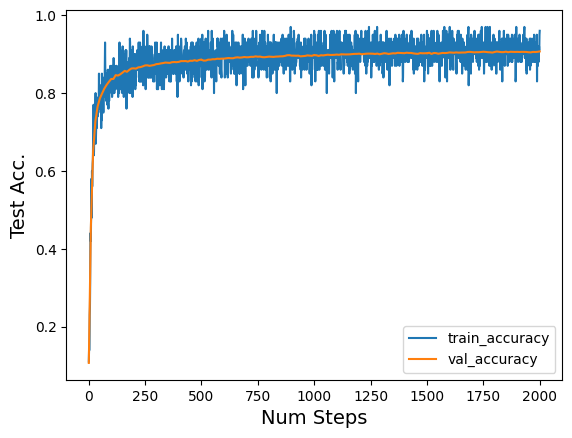

In [ ]:
fig = plt.figure()
plt.plot(train_step_bs100, train_accuracy_bs100, label='train_accuracy')
plt.plot(val_step_bs100, val_accuracy_bs100, label='val_accuracy')
plt.xlabel("Num Steps", fontsize=14)
plt.ylabel("Test Acc.", fontsize=14)
plt.legend()
plt.show()

<!-- END QUESTION -->

We will be using a batch size of 100 and a learning rate of 0.1 to evaluate the logistic regression classifier on the test set. Ideally, extensive hyperparamter tuning must be done on the validation set to choose the best possible hyperparameter configurations for our classifier.

In [ ]:
from tqdm import tqdm

def test_model(num_epochs: int, batch_size: int, learning_rate: float, validation_every_x_step: int, W_initial_weights: float) -> float:
    """
    Trains the logistic regression model

    Args:
        num_epochs (int): Number of epochs to train the model for
        batch_size (int): Size of the mini-batch
        learning_rate (float): Step size for mini-batch gradient descent optimization
        validation_every_x_step (int): Perform validation at every x-th step
        W_initial_weights (float): Randomly initialized weight matrix

    Returns:
        train_loss: list containing training losses at each epoch
        train_accuracy: list containing training accuracies at each epoch
        train_step:
        test_loss: list containing test losses at each epoch
        test_accuracy: list containing test accuracies at each epoch
        test_step:
    """

    train_loss = []
    train_accuracy = []
    train_step = []
    test_loss = []
    test_accuracy = []
    test_step = []
    epoch_last_step = 0

    model = LogisticRegressionModel(W_initial_weights)

    # note here that we have just replaced the validation set with the test set,
    # the rest of the procedure remains the same
    for i in tqdm(range(num_epochs)):
        epoch_train_loss, epoch_train_accuracy, epoch_train_step, \
             epoch_test_loss, epoch_test_accuracy, epoch_test_step = \
                train_one_epoch(model, train_set, train_labels, test_set,
                    test_labels, batch_size, learning_rate,
                    validation_every_x_step)

        train_loss += epoch_train_loss
        train_accuracy += epoch_train_accuracy
        train_step += [step + epoch_last_step for step in epoch_train_step]

        test_loss += epoch_test_loss
        test_accuracy += epoch_test_accuracy
        test_step += [step + epoch_last_step for step in epoch_test_step]

        epoch_last_step = train_step[-1]

    return train_loss, train_accuracy, train_step, test_loss, test_accuracy, test_step

100%|██████████| 100/100 [00:45<00:00,  2.19it/s]


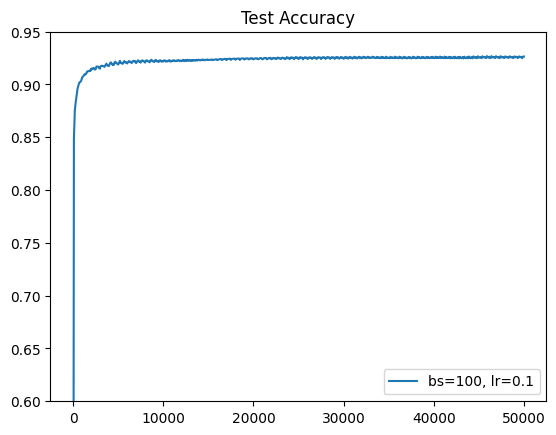

Best test accuracy: 92.65 %


In [ ]:
best_batch_size = 100
best_lr = 0.1

# Test the model!
_ , _ , _ , \
     test_loss, test_accuracy, test_step = test_model(num_epochs=100, batch_size=best_batch_size,
                                                        learning_rate=best_lr, validation_every_x_step=100, W_initial_weights=W_initial_weights)

fig = plt.figure()
plt.plot(test_step, test_accuracy, label=f"bs={best_batch_size}, lr={best_lr}")
plt.title('Test Accuracy')
plt.ylim(0.6, 0.95)
plt.legend()
plt.show()

print(f"Best test accuracy: {test_accuracy[-1] * 100.0} %")

<!-- END QUESTION -->

### 4. Comparing kNN, GNB and Logistic Regression Classifiers

Eventually, we will compare the performance of these 3 classifiers together. We will also compare the performance of above classifiers on FashionMNIST dataset.

Fashion MNIST typically acts a drop-in replacement for the well-known MNIST dataset. Its structure is quite similar to MNIST except the labels now represent fashion categories (instead of digits). Here's a table representing each category:

| Label      | Description |
| ----------- | ----------- |
| 0      | T-shirt/Top       |
| 1   | Trouser        |
| 2   | Pullover        |
| 3   | Dress        |
| 4   | Coat        |
| 5   | Sandal        |
| 6   | Shirt        |
| 7   | Sneaker        |
| 8   | Bag        |
| 9   | Ankle Boot        |
It is always important to visualize the data. In the next cell, we load the FashionMNIST dataset and plot 10 images from the training set

In [ ]:
def plot_fashion_mnist(images, labels, n_row=2, n_col=5):
  fig, axes = plt.subplots(n_row, n_col, figsize=(10, 5))
  for i in range(n_row * n_col):
      ax = axes[i//n_col, i%n_col]
      ax.imshow(images[i], cmap='gray')
      ax.set_title('Label: {}'.format(labels[i]))
  plt.tight_layout()
  plt.show()

4422102/4422102 [==============================] - 0s 0us/step
Number of images for training: 60000
Number of images for testing: 10000
Size of Fashion MNIST images: (28, 28)


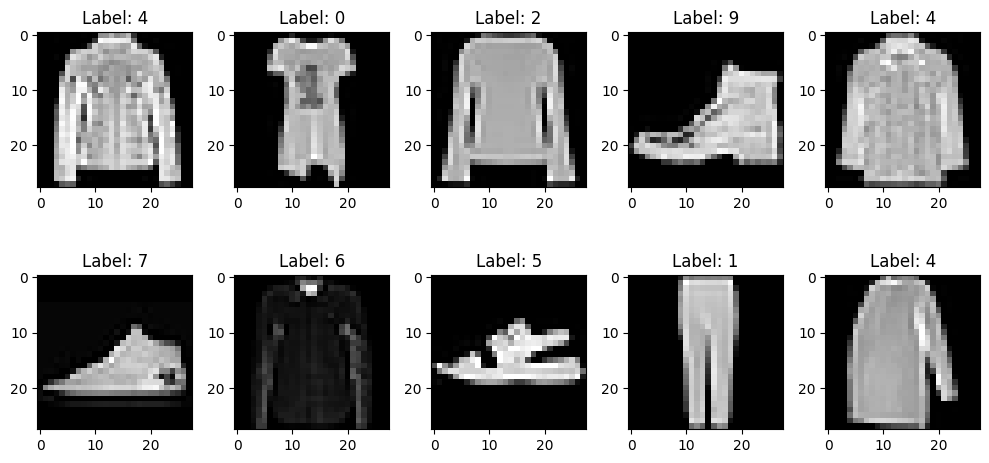

In [ ]:
# Load Fashion MNIST data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Shuffle the training set
permuted = np.random.permutation(len(x_train))
x_train, y_train = x_train[permuted], y_train[permuted]

print(f"Number of images for training: {x_train.shape[0]}")
print(f"Number of images for testing: {x_test.shape[0]}")
print(f"Size of Fashion MNIST images: {x_train[0].shape}")

# Visualize 10 images from the training set
plot_fashion_mnist(images=x_train[:10], labels=y_train[:10])

Now, normalize the training and test data with the function defined above.

In [ ]:
# NOTE: We normalize the training data by dividing the input by max value.
max_value = np.max(x_train)

train_images = x_train / max_value
test_images = x_test / max_value

# Vectorize the data
train_images = train_images.reshape((train_images.shape[0], -1))
test_images = test_images.reshape((test_images.shape[0], -1))

print(f"Training inputs' shape after vectorization: {train_images.shape}")
print(f"Testing inputs' shape after vectorization: {test_images.shape}")

Training inputs' shape after vectorization: (60000, 784)
Testing inputs' shape after vectorization: (10000, 784)


Now, using these functions, we will run the k-NN classifier on a subset of the FashionMNIST dataset! Particularly, we will use 50,000 samples for training, 10,000 samples for validation, and 10,000 samples for testing.

In [ ]:
n_train_samples = 50000
n_val_samples = 10000
n_test_samples = 10000

# define the training set and labels
train_set = train_images[:n_train_samples]
train_labels = y_train[:n_train_samples]
print(f"Training set shape: {train_set.shape}")

# define the validation set and labels
val_set = train_images[-n_val_samples:]
val_labels = y_train[-n_val_samples:]
print(f"Validaton set shape: {val_set.shape}")

# define the test set and labels
test_set = test_images[:n_test_samples]
test_labels = y_test[:n_test_samples]
print(f"Test set shape: {test_set.shape}")

Training set shape: (50000, 784)
Validaton set shape: (10000, 784)
Test set shape: (10000, 784)


#### Test all three classifiers on FashionMNIST dataset

In [ ]:
# kNN classifier (let's use the same best_k value we obtained for MNIST dataset)
knn_test_accuracy = knn_classifier(train_set, train_labels, test_set, test_labels, k=best_k)
print(f"\nkNN classifier: {knn_test_accuracy} %")


# GNB classifier
gnb_test_accuracy = gnb_classifier(train_set, train_labels, test_set, test_labels)
print(f"\nCNB classifier: {gnb_test_accuracy} %")

# Logistic regression
_, _, _,  _, log_test_accuracy, _ = test_model(num_epochs=100, batch_size=100,
                                             learning_rate=0.1, validation_every_x_step=100,
                                             W_initial_weights=W_initial_weights)
print(f"\nLogistic regression: {log_test_accuracy[-1] * 100.0} %")



kNN classifier: 96.53 %

CNB classifier: 77.27000000000001 %


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


Logistic regression: 92.65 %


What we can say now is that kNN accuracy = 96.53 %, GNB accuracy = 77.27 %, and Logistic regression accuracy = 92.65 % (with batch_size = 100 lr = 0.1

Out of the three, K-NN classifier performs the best.

This is because k-NN is a non-parametric algorithm, which means it doesn't make strong assumptions about the underlying data distribution. It can adapt well to different types of data.

## **Poission Regression**

In logistic regression, the assumption was that the binary label $Y_i \in \{0,1\}$ followed a Bernoulli distribution, in other words $\Pr(Y_i = 1 | X_i) = p_i$, where $p_i$ is the mean of the distribution. Under the independence assumption, the log-likelihood function could be derived as being
\begin{align}
\sum_{i=1}^n (1-y_i) \log(1-p_i) + y_i \log(p_i).
\end{align}
Then using the logit transformation, the parameterization we achieved was:
\begin{align}
\log\frac{p_i}{1-p_i} = {\bf x}_i . {\bf w} + b, \quad \mbox{ or equivalently } \quad p_i = \frac{1}{1+\exp(-{\bf x}_i . {\bf w} - b)}.
\end{align}
Furthemore, the weight vector and bias could both be found through maximizing the log-likelihood function.

The following problem attempts to generalize this to the case where $Y_i \in \mathbb{N}$, meaning that the outcome could be any natural number.


Assuming that each $Y_i \in \mathbb{N}$ follows the Poisson distribution (with mean $\mu_i \geq 0$):
	\begin{align}
	\Pr(Y_i = k | X_i) = \frac{\mu_i^k}{k!} \exp(-\mu_i), ~~ k = 0, 1, 2, \ldots
	\end{align}
Given a dataset $\mathcal{D} = \{{\bf x}_i, y_i\}_{i=1}^n$, the log-likelihood function (of $\mu_i$'s) given $\mathcal{D}$ is :



<strong><strong>
	\begin{align}
	\Pr(Y_i = y_i | X_i, μ_i) = \frac{\mu_i^{y_i}}{y_i!} \exp(-\mu_i),
	\end{align}

  So, with the independency of data,  \begin{align}
log(L) = \sum_{i=1}^n {y_i}log(μ_i)+log({y_i!})-μ_i.
\end{align}

We will using the parameterization below
	\begin{align}
	\log\mu_i = {\bf x}_i . {\bf w} + b.
	\end{align}

Indeed as we did the transformation with the log odds for logistic regression to find a linear relation between the log of parameter we want to approximate and the input, we can do the same with poisson regression.


<br>
We want to minimize the following expression :
\begin{align}
log(L) = \sum_{i=1}^n {y_i}(xi.w+b).+log({y_i!})-e^{xi.w+b.}.
\end{align}

We thus compute the gradient of our objective function above.

so we've,
$$
\begin{aligned}
    ∇w(log(L)) =
        (\frac{\partial \sum_{i=1}^n {y_i}(xi.w+b).+log({y_i!})-e^{xi.w+b.}}{\partial w_j})_{1\leq j \leq p}
  \end{aligned}
$$
<br><br>
$$
\begin{aligned}
     =
        ({\sum_{i=1}^n {y_i}(x_i^{(j)})-(x_i^{(j)})*e^{xi.w+b.}})_{1\leq j \leq p}
  \end{aligned}
$$
<br>

Where, p = len(W)




<!-- END QUESTION -->

